# Week One Final Project: NBA Salary Prediction and Exploration

Where has week one gone! We have one more project for you to put a nice little bow on all of the hard work you've done so far. For this project, be persistent, be curious, and ask questions if you get stuck!

## The Project

You and your teammates will create one prediction model and *AT LEAST* three plots or charts. Everyone will present their model and their charts during the final session of the day.
* Model predictions will be ranked according to their r-squared values and we will crown a winner!
* Your plots should be driven by curiosity. Everyone will present at least one plot.

## Helper Functions

We've provided helper functions down below. If you need help remembering what they do, refer to the `airbnb_solution.ipynb` example in the `3 - Day Three` folder.

## Let's Get Started: Reading and preparing the data

You'll need to use a lot of existing libraries and packages to look at the data. The cell below imports what you need into this notebook.

In [1]:
# We'll use these packages
import pandas as pd
import numpy as np
import ast
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

The cell below limits how many columns to show at once. Some data can be quite large, and you don't want to overload your notebook. For the nba data we are looking at, we shouldn't run into this issue, but it's a good practice to run a cell like this when analyzing data.

In [2]:
pd.set_option('display.max_columns', 100)

Next, let's read the data from the csv file. The dataset we will be using contains statistics and salary information for NBA players during the 2022-2023 season.

[Link to dataset source and information](https://www.kaggle.com/datasets/jamiewelsh2/nba-player-salaries-2022-23-season)

**You will be looking for features of the data that can model (or predict) any of the players' salaries.**

In [3]:
# Read in the data!
nba_data = pd.read_csv("nba_dataset.csv")

Take a look at the first five rows of the data using the `df.head()` method.

In [4]:
nba_data.head()

,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Total Minutes,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,20.2,0.493,4.9,11.4,0.427,5.1,8.8,0.579,0.614,4.6,5.0,0.915,0.7,5.4,6.1,6.3,0.9,0.4,3.2,2.1,29.4,1941,24.1,0.656,0.564,0.248,2.3,16.8,9.7,30.0,1.3,0.9,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,9.9,0.408,1.0,3.2,0.303,3.1,6.7,0.459,0.457,2.3,3.3,0.681,0.4,2.3,2.7,5.2,0.8,0.4,2.4,1.7,11.4,755,13.6,0.498,0.322,0.334,2.1,11.4,6.8,35.3,1.8,1.4,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,13.6,0.436,1.2,3.9,0.311,4.7,9.7,0.487,0.481,2.8,4.3,0.656,1.2,4.6,5.8,7.5,1.0,0.5,3.5,2.2,15.9,2126,16.1,0.513,0.289,0.317,4.7,16.5,10.8,38.6,1.7,1.3,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
3,3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,22.2,0.500,2.2,6.9,0.321,8.9,15.3,0.580,0.549,4.6,5.9,0.768,1.2,7.1,8.3,6.8,0.9,0.6,3.2,1.6,28.9,1954,23.9,0.583,0.309,0.268,3.7,20.8,12.5,33.5,1.2,1.4,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0
4,4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,18.3,0.560,2.0,4.9,0.404,8.3,13.4,0.617,0.614,6.5,7.1,0.919,0.4,6.3,6.7,5.0,0.7,1.4,3.3,2.1,29.1,1672,25.9,0.677,0.267,0.387,1.2,19.5,10.5,24.5,1.0,3.4,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9


### Helper Function 1: Splitting up text data that differs within the column

Sometimes column data will be in text form, but you still want to use it in your analysis. The next five code cells help you to modify the data so that it can be used for this type of analysis.

For example, some positions might have higher salaries than others, but you currently can't look at individual positions because they are all in one column.

Since you can't examine text data, the code below will to split each position out into it's own column, and indicate with a `1` or `0` whether the player played that position. While there may seem like better ways to view this data from a human perspective, this is considered *'best practice'* in data science.

The code below splits out the selected column (`Position`) into its own `dataframe`, making each value a new column. It then stores the 'dummy' dataframe in a new variable called `position_dummies`.

In [5]:
# Helper function for splitting out text data that differs by column, but is representing a category
# like genre, or artist, but not something track name
position_dummies = pd.get_dummies(nba_data["Position"])
position_dummies

,C,PF,PG,PG-SG,SF,SF-PF,SF-SG,SG,SG-PG
0,False,False,True,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
462,False,False,False,False,True,False,False,False,False
463,False,False,False,False,False,False,False,True,False
464,False,False,False,False,False,False,False,True,False
465,False,True,False,False,False,False,False,False,False


This process creates new columns. The cell below stores all these new column header names in a variable called `team_dummies_columns` so that you can easily look it up later if you need.

In [6]:
position_dummies_columns = position_dummies.columns

Now you can take a look at those column names using the code cell below.

In [7]:
position_dummies_columns

Index(['C', 'PF', 'PG', 'PG-SG', 'SF', 'SF-PF', 'SF-SG', 'SG', 'SG-PG'], dtype='object')

Now that you have a dataframe that you can use, combine your two separate dataframes (`nba_data` and `position_dummies`) using the `pandas.concat()` method, which will concatenate `position_dummies` onto the end of `nba_data`.

The cell below does this work, and then stores this new dataframe in a variable called `merged_data`. 

In [8]:
#genre_dummies is it's own dataframe, I want to contatenate it onto my nba_data
merged_data = pd.concat([nba_data, position_dummies], axis=1)
merged_data

,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Total Minutes,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,C,PF,PG,PG-SG,SF,SF-PF,SF-SG,SG,SG-PG
0,0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,20.2,0.493,4.9,11.4,0.427,5.1,8.8,0.579,0.614,4.6,5.0,0.915,0.7,5.4,6.1,6.3,0.9,0.4,3.2,2.1,29.4,1941,24.1,0.656,0.564,0.248,2.3,16.8,9.7,30.0,1.3,0.9,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7,False,False,True,False,False,False,False,False,False
1,1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,9.9,0.408,1.0,3.2,0.303,3.1,6.7,0.459,0.457,2.3,3.3,0.681,0.4,2.3,2.7,5.2,0.8,0.4,2.4,1.7,11.4,755,13.6,0.498,0.322,0.334,2.1,11.4,6.8,35.3,1.8,1.4,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1,False,False,True,False,False,False,False,False,False
2,2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,13.6,0.436,1.2,3.9,0.311,4.7,9.7,0.487,0.481,2.8,4.3,0.656,1.2,4.6,5.8,7.5,1.0,0.5,3.5,2.2,15.9,2126,16.1,0.513,0.289,0.317,4.7,16.5,10.8,38.6,1.7,1.3,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2,False,False,True,False,False,False,False,False,False
3,3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,22.2,0.500,2.2,6.9,0.321,8.9,15.3,0.580,0.549,4.6,5.9,0.768,1.2,7.1,8.3,6.8,0.9,0.6,3.2,1.6,28.9,1954,23.9,0.583,0.309,0.268,3.7,20.8,12.5,33.5,1.2,1.4,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0,False,True,False,False,False,False,False,False,False
4,4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,18.3,0.560,2.0,4.9,0.404,8.3,13.4,0.617,0.614,6.5,7.1,0.919,0.4,6.3,6.7,5.0,0.7,1.4,3.3,2.1,29.1,1672,25.9,0.677,0.267,0.387,1.2,19.5,10.5,24.5,1.0,3.4,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,462,Justin Minaya,35096,SF,23,POR,4,0,22.3,1.8,5.8,0.304,0.8,3.0,0.250,1.0,2.8,0.364,0.370,0.0,0.3,0.000,0.8,3.0,3.8,1.0,0.5,1.3,1.0,2.3,4.3,89,4.0,0.363,0.522,0.043,3.8,15.6,9.7,5.9,1.1,5.0,14.6,13.4,-0.2,0.1,-0.1,-0.067,-7.2,-1.9,-9.0,-0.2,False,False,False,False,True,False,False,False,False
463,463,Kobi Simmons,32795,SG,25,CHO,5,0,5.6,0.2,1.2,0.167,0.2,1.0,0.200,0.0,0.2,0.000,0.250,0.4,0.4,1.000,0.2,0.6,0.8,1.0,0.0,0.4,0.2,0.0,1.0,28,9.0,0.363,0.833,0.333,3.7,11.7,7.6,21.8,0.0,6.2,12.7,11.8,0.0,0.0,0.0,0.019,-1.0,0.1,-0.9,0.0,False,False,False,False,False,False,False,True,False
464,464,Gabe York,32171,SG,29,IND,3,0,18.7,2.7,7.0,0.381,2.0,6.0,0.333,0.7,1.0,0.667,0.524,0.7,0.7,1.000,0.0,2.0,2.0,1.7,0.7,0.0,0.0,1.7,8.0,56,11.8,0.548,0.857,0.095,0.0,11.9,5.9,12.3,1.7,0.0,0.0,16.4,0.1,0.0,0.1,0.091,-1.7,-1.8,-3.5,0.0,False,False,False,False,False,False,False,True,False
465,465,RaiQuan Gray,5849,PF,23,BRK,1,0,35.0,6.0,12.0,0.500,2.0,5.0,0.400,4.0,7.0,0.571,0.583,2.0,2.0,1.000,3.0,6.0,9.0,7.0,0.0,1.0,4.0,5.0,16.0,35,15.5,0.621,0.417,0.167,9.9,18.8,14.4,29.0,0.0,2.4,23.7,21.4,0.0,0.0,0.1,0.106,-0.6,-1.4,-2.0,0.0,False,True,False,False,False,False,False,False,False


Finally, since you're going to be doing the rest of the analysis using the `nba_data` variable, put this `merged_data` information into that variable by reassigning `nba_data`.

***Note: you may want to repeat this process for 'Team' if that interests you***

In [9]:
nba_data = merged_data
nba_data

,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Total Minutes,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,C,PF,PG,PG-SG,SF,SF-PF,SF-SG,SG,SG-PG
0,0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,20.2,0.493,4.9,11.4,0.427,5.1,8.8,0.579,0.614,4.6,5.0,0.915,0.7,5.4,6.1,6.3,0.9,0.4,3.2,2.1,29.4,1941,24.1,0.656,0.564,0.248,2.3,16.8,9.7,30.0,1.3,0.9,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7,False,False,True,False,False,False,False,False,False
1,1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,9.9,0.408,1.0,3.2,0.303,3.1,6.7,0.459,0.457,2.3,3.3,0.681,0.4,2.3,2.7,5.2,0.8,0.4,2.4,1.7,11.4,755,13.6,0.498,0.322,0.334,2.1,11.4,6.8,35.3,1.8,1.4,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1,False,False,True,False,False,False,False,False,False
2,2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,13.6,0.436,1.2,3.9,0.311,4.7,9.7,0.487,0.481,2.8,4.3,0.656,1.2,4.6,5.8,7.5,1.0,0.5,3.5,2.2,15.9,2126,16.1,0.513,0.289,0.317,4.7,16.5,10.8,38.6,1.7,1.3,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2,False,False,True,False,False,False,False,False,False
3,3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,22.2,0.500,2.2,6.9,0.321,8.9,15.3,0.580,0.549,4.6,5.9,0.768,1.2,7.1,8.3,6.8,0.9,0.6,3.2,1.6,28.9,1954,23.9,0.583,0.309,0.268,3.7,20.8,12.5,33.5,1.2,1.4,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0,False,True,False,False,False,False,False,False,False
4,4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,18.3,0.560,2.0,4.9,0.404,8.3,13.4,0.617,0.614,6.5,7.1,0.919,0.4,6.3,6.7,5.0,0.7,1.4,3.3,2.1,29.1,1672,25.9,0.677,0.267,0.387,1.2,19.5,10.5,24.5,1.0,3.4,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,462,Justin Minaya,35096,SF,23,POR,4,0,22.3,1.8,5.8,0.304,0.8,3.0,0.250,1.0,2.8,0.364,0.370,0.0,0.3,0.000,0.8,3.0,3.8,1.0,0.5,1.3,1.0,2.3,4.3,89,4.0,0.363,0.522,0.043,3.8,15.6,9.7,5.9,1.1,5.0,14.6,13.4,-0.2,0.1,-0.1,-0.067,-7.2,-1.9,-9.0,-0.2,False,False,False,False,True,False,False,False,False
463,463,Kobi Simmons,32795,SG,25,CHO,5,0,5.6,0.2,1.2,0.167,0.2,1.0,0.200,0.0,0.2,0.000,0.250,0.4,0.4,1.000,0.2,0.6,0.8,1.0,0.0,0.4,0.2,0.0,1.0,28,9.0,0.363,0.833,0.333,3.7,11.7,7.6,21.8,0.0,6.2,12.7,11.8,0.0,0.0,0.0,0.019,-1.0,0.1,-0.9,0.0,False,False,False,False,False,False,False,True,False
464,464,Gabe York,32171,SG,29,IND,3,0,18.7,2.7,7.0,0.381,2.0,6.0,0.333,0.7,1.0,0.667,0.524,0.7,0.7,1.000,0.0,2.0,2.0,1.7,0.7,0.0,0.0,1.7,8.0,56,11.8,0.548,0.857,0.095,0.0,11.9,5.9,12.3,1.7,0.0,0.0,16.4,0.1,0.0,0.1,0.091,-1.7,-1.8,-3.5,0.0,False,False,False,False,False,False,False,True,False
465,465,RaiQuan Gray,5849,PF,23,BRK,1,0,35.0,6.0,12.0,0.500,2.0,5.0,0.400,4.0,7.0,0.571,0.583,2.0,2.0,1.000,3.0,6.0,9.0,7.0,0.0,1.0,4.0,5.0,16.0,35,15.5,0.621,0.417,0.167,9.9,18.8,14.4,29.0,0.0,2.4,23.7,21.4,0.0,0.0,0.1,0.106,-0.6,-1.4,-2.0,0.0,False,True,False,False,False,False,False,False,False


### Helper Function 2: Splitting up data in dictionary form

Sometimes data will come in a dictionary form, which looks like:

```
{
    'rock': 'False',
    'rap': 'True',
    'country': 'False,
    ...
}
```
This data isn't in a great form to do numerical analysis with, so the code cell below can be useful to create individual columns based on the keys in the dictionary.

There is no data that is in dictionary form in the NBA dataset we are looking at, so it doesn't need to be run. This notebook is set up so that you can use different data in the future, so keep this helper function around.

In [ ]:
# DON'T USE THIS IF YOU DONT HAVE ANY DATA IN A DICTIONARY FORM

# Helper Function: Feature Engineering
# Use this to turn dictionary columns into useful features
# We use the genre column as an example

column = "column"  # FEEL FREE TO CHANGE THIS
number_to_keep = 100

def process_col_name(col_name):
    col_name_list = ast.literal_eval(col_name)
    if not isinstance(col_name_list, list):
        return []
    return [dic['name'] for dic in col_name_list if isinstance(dic, dict) and 'name' in dic]

nba_data[f'{column}_list'] = nba_data[column].apply(process_col_name)

# Compute the frequency of each col_name member
freq = pd.Series([name for sublist in nba_data[f'{column}_list'].tolist() for name in sublist]).value_counts()

# Keep the top 100 most frequent col_name members
top_col_name = freq[:number_to_keep].index.tolist()

# Filter the lists in the column to only include top col_name members
nba_data[f'{column}_list'] = nba_data[f'{column}_list'].apply(lambda x: [i for i in x if i in top_col_name])

mlb = MultiLabelBinarizer()

binary_matrix = pd.DataFrame(mlb.fit_transform(nba_data[f'{column}_list']), columns=mlb.classes_)

# Clean the column names: keep only alphanumeric characters and underscores
binary_matrix.columns = binary_matrix.columns.str.replace('[^0-9a-zA-Z_]', '', regex=True)

# Now, concatenate the binary matrix with the original DataFrame
new_feature_names = binary_matrix.columns
nba_data = pd.concat([nba_data, binary_matrix], axis=1)

## Looking at the Data: Plotting

The two code cells below help you to look at data in different ways using the **bar** plot and **scatter** plot functionality of dataframes.

***To complete the challenge, you will need to have three (3) different plots that told you something about the data.***

Play around with different columns to look at and compare. You will need to create at least one new code cell to add your third plot, which can be either a bar plot or a scatter plot. 

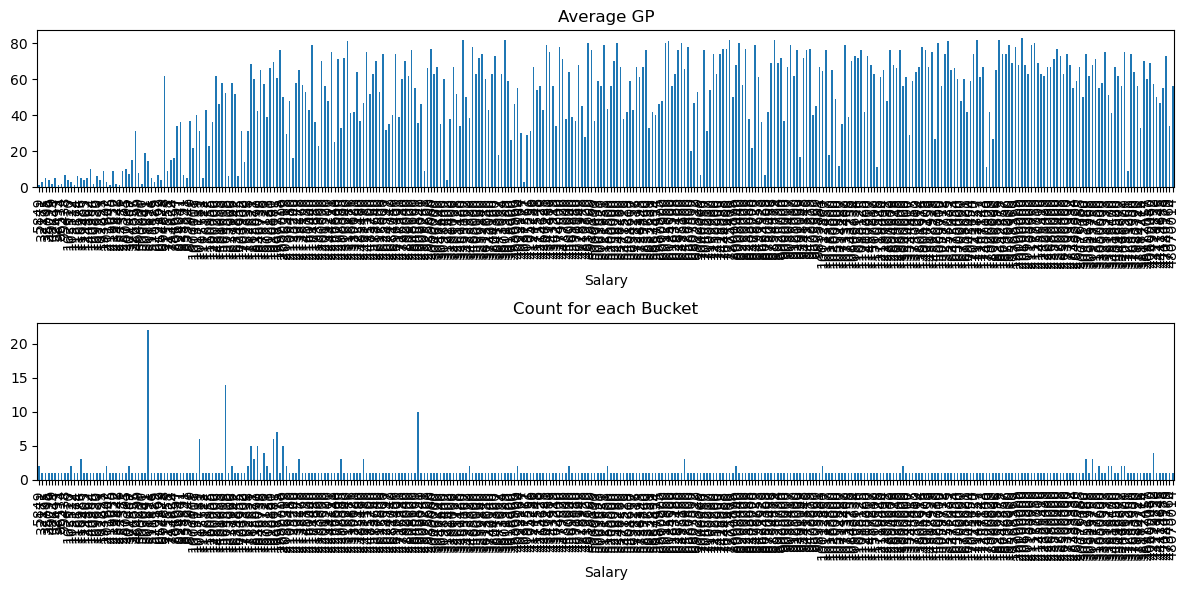

In [12]:
# Helper Function: Two Bar Chart Plots
groupby_variable = "Salary"
y_value = "GP"

fig, axs = plt.subplots(2, 1, figsize=(12, 6))
nba_data.groupby(groupby_variable)[y_value].mean().plot(kind="bar", ax=axs[0], title=f"Average {y_value}")
nba_data.groupby(groupby_variable)[y_value].count().plot(kind="bar", ax=axs[1], title=f"Count for each Bucket")
fig.tight_layout()

<Axes: xlabel='Salary', ylabel='3P'>

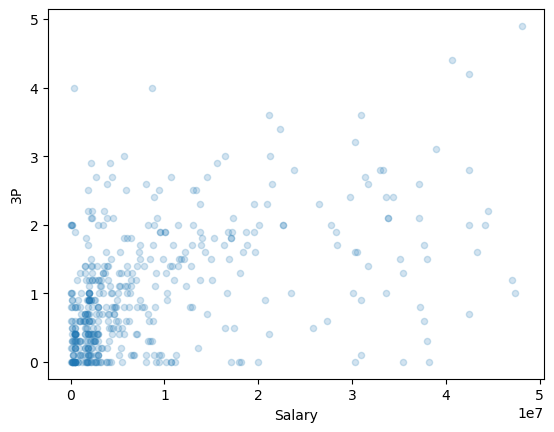

In [15]:
# Helper Function: Scatter Plot

x_value = "Salary"
y_value = "3P"

nba_data.plot(x=x_value, y=y_value, kind="scatter", alpha=0.2)

<Axes: xlabel='Salary', ylabel='PTS'>

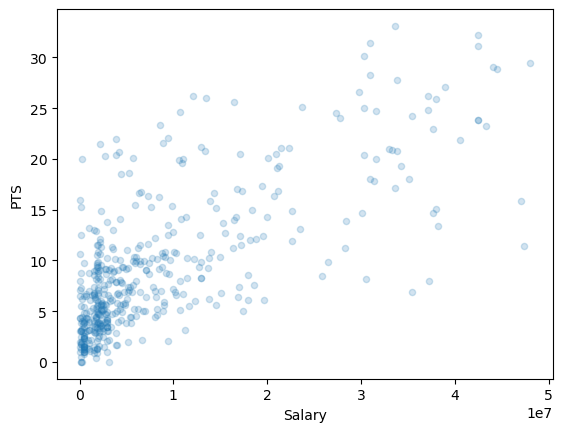

In [16]:
# Helper Function: Scatter Plot

x_value = "Salary"
y_value = "PTS"

nba_data.plot(x=x_value, y=y_value, kind="scatter", alpha=0.2)

## Model Training: Selecting features to explain something

The code cell below will support you in training a model that predicts the salary of any player.

This is a *'regression'* model, meaning that it tries to predict a value, as opposed to *'classification'* which identifies a singular class.

Basically, you are looking for what combination of the columns, which we call features, can predict how much a player in this dataset was paid. The model training part then works out how much of a weight to put on those features.

The cell below will give a list of all of the options that you can use for features (just don't use 'salary', that's what you're trying to predict).

Select some of these columns to include in the `features` variable list (it can be longer than 3).

***The output of this cell will have a lot of information***  
What you are looking for is the `R**2` value under the `Validation Data Statistics`.

In [18]:
list(nba_data.columns)

['Unnamed: 0',
 'Player Name',
 'Salary',
 'Position',
 'Age',
 'Team',
 'GP',
 'GS',
 'MP',
 'FG',
 'FGA',
 'FG%',
 '3P',
 '3PA',
 '3P%',
 '2P',
 '2PA',
 '2P%',
 'eFG%',
 'FT',
 'FTA',
 'FT%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'Total Minutes',
 'PER',
 'TS%',
 '3PAr',
 'FTr',
 'ORB%',
 'DRB%',
 'TRB%',
 'AST%',
 'STL%',
 'BLK%',
 'TOV%',
 'USG%',
 'OWS',
 'DWS',
 'WS',
 'WS/48',
 'OBPM',
 'DBPM',
 'BPM',
 'VORP',
 'C',
 'PF',
 'PG',
 'PG-SG',
 'SF',
 'SF-PF',
 'SF-SG',
 'SG',
 'SG-PG']

In [36]:
list(nba_data['FG%'])

[0.493,
 0.408,
 0.436,
 0.5,
 0.56,
 0.506,
 0.512,
 0.457,
 0.553,
 0.463,
 0.436,
 0.494,
 0.659,
 0.436,
 0.563,
 0.539,
 0.501,
 0.421,
 0.429,
 0.485,
 0.566,
 0.48,
 0.548,
 0.479,
 0.495,
 0.494,
 0.473,
 0.548,
 0.437,
 0.441,
 0.454,
 0.484,
 0.469,
 0.484,
 0.51,
 0.589,
 0.389,
 0.466,
 0.54,
 0.512,
 0.475,
 0.491,
 0.44,
 0.404,
 0.491,
 0.504,
 0.476,
 0.527,
 0.459,
 0.508,
 0.428,
 0.484,
 0.447,
 0.415,
 0.393,
 0.458,
 0.615,
 0.475,
 0.564,
 0.468,
 0.644,
 0.42,
 0.446,
 0.438,
 0.431,
 0.457,
 0.473,
 0.653,
 0.337,
 0.597,
 0.415,
 0.476,
 0.415,
 0.462,
 0.464,
 0.671,
 0.371,
 0.479,
 0.506,
 0.514,
 0.499,
 0.426,
 0.395,
 0.388,
 0.379,
 0.438,
 0.384,
 0.485,
 0.515,
 0.462,
 0.531,
 0.4,
 0.457,
 0.492,
 0.608,
 0.444,
 0.45,
 0.448,
 0.529,
 0.391,
 0.499,
 0.493,
 0.445,
 0.431,
 0.466,
 0.449,
 0.43,
 0.411,
 0.396,
 0.618,
 0.732,
 0.427,
 0.434,
 0.496,
 0.765,
 0.459,
 0.747,
 0.415,
 0.485,
 0.419,
 0.479,
 0.634,
 0.409,
 0.436,
 0.461,
 0.558,
 0.3

In [35]:
nba_data['FG%'].fillna(0)

0      0.493
1      0.408
2      0.436
3      0.500
4      0.560
       ...  
462    0.304
463    0.167
464    0.381
465    0.500
466    0.333
Name: FG%, Length: 467, dtype: float64

In [43]:
nba_data = nba_data.dropna()

Training Data Statistics
mean_absolute_error:  5380143.7292672545
mean_squared_error 52503341059793.52
R**2 0.5599924696715565

Validation Data Statistics
mean_absolute_error:  5794148.488948278
mean_squared_error 56395413096710.03
R**2 0.5177932186565746


C:\Users\chtva\AppData\Local\Temp\ipykernel_20712\4223405956.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[f"predicted_{target}"] = model.predict(train_data[features])
C:\Users\chtva\AppData\Local\Temp\ipykernel_20712\4223405956.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data[f"predicted_{target}"] = model.predict(validation_data[features])


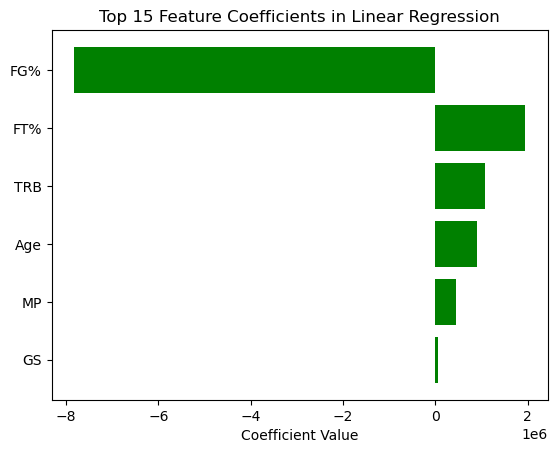

In [45]:
# Helper Function: Model Training
# DO NOT USE YOUR TARGET COLUMN IN THE FEATURES
features = ["GS", "FG%", "MP", "TRB", "FT%", "Age"]

target = "Salary"  # LEAVE THIS ALONE
model_type = "linear regression"  # Options: "random forest" or "linear regression"
features_to_show = 15


if model_type == "random forest":
    model = RandomForestRegressor()
elif model_type == "linear regression":
    model = LinearRegression()

shuffled_data = nba_data.sample(len(nba_data))  # Shuffle our data
train_data = shuffled_data[:int(len(shuffled_data)*0.8)]
validation_data = shuffled_data[int(len(shuffled_data)*0.8):]

model.fit(train_data[features], train_data[target])

train_data[f"predicted_{target}"] = model.predict(train_data[features])
validation_data[f"predicted_{target}"] = model.predict(validation_data[features])

# How do we measure our success?
print("Training Data Statistics")
print("mean_absolute_error: ", mean_absolute_error(train_data[target], train_data[f"predicted_{target}"]))
print("mean_squared_error", mean_squared_error(train_data[target], train_data[f"predicted_{target}"]))
print("R**2", r2_score(train_data[target], train_data[f"predicted_{target}"]))
print("")

print("Validation Data Statistics")
print("mean_absolute_error: ", mean_absolute_error(validation_data[target], validation_data[f"predicted_{target}"]))
print("mean_squared_error", mean_squared_error(validation_data[target], validation_data[f"predicted_{target}"]))
print("R**2", r2_score(validation_data[target], validation_data[f"predicted_{target}"]))

if model_type == "random forest":
    importances = model.feature_importances_
    indices = np.argsort(importances)[-features_to_show:]  # sort top features

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Bar plot
    ax.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.title(f'Top {features_to_show} Feature Importances')
    plt.show()

if model_type == "linear regression":
    coefficients = model.coef_
    indices = np.argsort(np.abs(coefficients))[-features_to_show:]  # sort top features by magnitude

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Bar plot
    ax.barh(range(len(indices)), coefficients[indices], color='g', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Coefficient Value')
    plt.title(f'Top {features_to_show} Feature Coefficients in Linear Regression')
    plt.show()